## Interpretability Result in FedMA

In this jupyter notebook, we provide the code to reproduce the "Interpretability" experiments (see Section 3 for more details) in FedMA paper.

In [1]:
import pickle
import copy
from sklearn.preprocessing import normalize
from utils import *

from matching.pfnm import layer_wise_group_descent
from matching.pfnm import layer_wise_group_descent_comm, layer_wise_group_descent_comm2, layer_wise_group_descent_comm3
from matching.pfnm import block_patching, patch_weights
from matching.gaus_marginal_matching import match_local_atoms

import logging

from model import *

In [2]:
dummy_cnn = ModerateCNN()
layer_type = []
for (k, v) in dummy_cnn.state_dict().items():
    layer_type.append(k)

In [3]:
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [4]:
# we load retrained weights here:
with open("./first_round_retraining_weights", "rb") as out_file:
    batch_weights = pickle.load(out_file)

In [5]:
n_layers = int(len(batch_weights[0]) / 2)
num_workers = len(batch_weights)

matching_shapes_old = []
matching_shapes_new = []

first_fc_index = None
gamma = 5.0
sigma = 1.0
sigma0 = 1.0
n_classes = 10
it=5

In [6]:
args_dataset = "cifar10"
args_datadir = "./data/cifar10"
args_batch_size = 64

train_dl_global, test_dl_global = get_dataloader(args_dataset, args_datadir, args_batch_size, 32)
matching_shapes = []

Files already downloaded and verified
Files already downloaded and verified


In [7]:
def ___trans_next_conv_layer_forward(layer_weight, next_layer_shape):
    reshaped = layer_weight.reshape(next_layer_shape).transpose((1, 0, 2, 3)).reshape((next_layer_shape[1], -1))
    return reshaped

def ___trans_next_conv_layer_backward(layer_weight, next_layer_shape):
    reconstructed_next_layer_shape = (next_layer_shape[1], next_layer_shape[0], next_layer_shape[2], next_layer_shape[3])
    reshaped = layer_weight.reshape(reconstructed_next_layer_shape).transpose(1, 0, 2, 3).reshape(next_layer_shape[0], -1)
    return reshaped

In [8]:
import copy

test_weight = copy.deepcopy(batch_weights[0][2])

print(batch_weights[0][0].shape)
print(test_weight.shape)

next_layer_shape = (70, 32, 3, 3)

reshaped_weight = ___trans_next_conv_layer_forward(test_weight, next_layer_shape)
reshaped_back_weight = ___trans_next_conv_layer_backward(reshaped_weight, next_layer_shape)

print("Are those weights equal: {}".format(np.array_equal(test_weight, reshaped_back_weight)))

(32, 27)
(70, 288)
Are those weights equal: True


In [9]:
def compute_full_cnn_accuracy(models, weights, train_dl, test_dl, n_classes, args_model, args_dataset):
    """Note that we only handle the FC weights for now"""
    # we need to figure out the FC dims first

    #LeNetContainer
    # def __init__(self, num_filters, kernel_size, input_dim, hidden_dims, output_dim=10)

    # this should be safe to be hard-coded since most of the modern image classification dataset are in RGB format
    #args_n_nets = len(models)

    if args_model == "lenet":
        num_filters = [weights[0].shape[0], weights[2].shape[0]]
        kernel_size = 5
        input_dim = weights[4].shape[0]
        hidden_dims = [weights[4].shape[1]]

        output_dim = weights[-1].shape[0]

        logger.info("Num filters: {}, Input dim: {}, hidden_dims: {}, output_dim: {}".format(num_filters, input_dim, hidden_dims, output_dim))

        matched_cnn = LeNetContainer(
                                    num_filters=num_filters,
                                    kernel_size=kernel_size,
                                    input_dim=input_dim,
                                    hidden_dims=hidden_dims,
                                    output_dim=output_dim)
    elif args_model == "vgg":
        matched_shapes = [w.shape for w in weights]
        matched_cnn = matched_vgg11(matched_shapes=matched_shapes)
    elif args_model == "simple-cnn":
        # input_channel, num_filters, kernel_size, input_dim, hidden_dims, output_dim=10):
        # [(9, 75), (9,), (19, 225), (19,), (475, 123), (123,), (123, 87), (87,), (87, 10), (10,)]
        if args_dataset in ("cifar10", "cinic10"):
            input_channel = 3
        elif args_dataset == "mnist":
            input_channel = 1
        num_filters = [weights[0].shape[0], weights[2].shape[0]]
        input_dim = weights[4].shape[0]
        hidden_dims = [weights[4].shape[1], weights[6].shape[1]]
        matched_cnn = SimpleCNNContainer(input_channel=input_channel, 
                                        num_filters=num_filters, 
                                        kernel_size=5, 
                                        input_dim=input_dim, 
                                        hidden_dims=hidden_dims, 
                                        output_dim=10)
    elif args_model == "moderate-cnn":
        #[(35, 27), (35,), (68, 315), (68,), (132, 612), (132,), (132, 1188), (132,), 
        #(260, 1188), (260,), (260, 2340), (260,), 
        #(4160, 1025), (1025,), (1025, 515), (515,), (515, 10), (10,)]
        num_filters = [weights[0].shape[0], weights[2].shape[0], weights[4].shape[0], weights[6].shape[0], weights[8].shape[0], weights[10].shape[0]]
        input_dim = weights[12].shape[0]
        hidden_dims = [weights[12].shape[1], weights[14].shape[1]]
        if args_dataset in ("cifar10", "cinic10"):
            matched_cnn = ModerateCNNContainer(3,
                                                num_filters, 
                                                kernel_size=3, 
                                                input_dim=input_dim, 
                                                hidden_dims=hidden_dims, 
                                                output_dim=10)
        elif args_dataset == "mnist":
            matched_cnn = ModerateCNNContainer(1,
                                                num_filters, 
                                                kernel_size=3, 
                                                input_dim=input_dim, 
                                                hidden_dims=hidden_dims, 
                                                output_dim=10)

    #logger.info("Keys of layers of convblock ...")
    new_state_dict = {}
    model_counter = 0
    # handle the conv layers part which is not changing
    for param_idx, (key_name, param) in enumerate(matched_cnn.state_dict().items()):
        #print("&"*30)
        #print("Key: {}, Weight Shape: {}, Matched weight shape: {}".format(key_name, param.size(), weights[param_idx].shape))
        #print("&"*30)
        if "conv" in key_name or "features" in key_name:
            if "weight" in key_name:
                temp_dict = {key_name: torch.from_numpy(weights[param_idx].reshape(param.size()))}
            elif "bias" in key_name:
                temp_dict = {key_name: torch.from_numpy(weights[param_idx])}
        elif "fc" in key_name or "classifier" in key_name:
            if "weight" in key_name:
                temp_dict = {key_name: torch.from_numpy(weights[param_idx].T)}
            elif "bias" in key_name:
                temp_dict = {key_name: torch.from_numpy(weights[param_idx])}

        new_state_dict.update(temp_dict)
    matched_cnn.load_state_dict(new_state_dict)

    matched_cnn.eval()
    ##    
    
    correct, total = 0, 0
    for batch_idx, (x, target) in enumerate(test_dl):
        out_k = matched_cnn(x)
        _, pred_label = torch.max(out_k, 1)
        total += x.data.size()[0]
        correct += (pred_label == target.data).sum().item()
        
    logger.info("Accuracy for Neural Matching correct: {}, total: {}".format(correct, total))
    

class ModerateCNNContainerConvBlocks(nn.Module):
    def __init__(self, num_filters, output_dim=10):
        super(ModerateCNNContainerConvBlocks, self).__init__()

        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=num_filters[0], kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.Conv2d(in_channels=num_filters[0], out_channels=num_filters[1], kernel_size=3, padding=1),
            #nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv_layer(x)
        return x

In [10]:
layer_index = 1
model_meta_data = [(32, 3, 3, 3), (32, ), (70, 32, 3, 3), (70,)]
logger.info("Handling layer: {}".format(layer_index))
layer_hungarian_weights_old, assignment_old, L_next_old = layer_wise_group_descent_comm(
     batch_weights=batch_weights, 
     layer_index=layer_index,
     sigma0_layers=sigma0, 
     sigma_layers=sigma, 
     batch_frequencies=None, 
     it=it, 
     gamma_layers=gamma, 
     model_meta_data=model_meta_data,
     model_layer_type=layer_type,
     n_layers=n_layers,
     matching_shapes=matching_shapes,
     args=None
     )
matching_shapes_old.append(L_next_old)

INFO:root:Handling layer: 1
INFO:root:init_channel_kernel_dims: [27, 288, 630, 1197, 1206, 2367, 1025, 516, 10]
INFO:root:Layer index: 1, init_num_kernel: 32
INFO:root:weights bias: (32, 28)
INFO:root:sigma_inv_prior shape: (28,)
INFO:root:mean_prior shape: (28,)
INFO:root:Number of global neurons is 34, gamma 5.000000
INFO:root:***************Shape of global weights after match: (34, 28) ******************
INFO:root:Branch A, Layer index: 1, Global weights out shapes: [(34, 27), (34,)]
INFO:root:global inv sigma out shape: [(34, 27), (34,)]


In [11]:
layer_index = 1
model_meta_data = [(32, 3, 3, 3), (32, ), (70, 32, 3, 3), (70,)]
logger.info("Handling layer: {}".format(layer_index))
layer_hungarian_weights_new, assignment_new, L_next_new = layer_wise_group_descent_comm3(
     batch_weights=batch_weights, 
     layer_index=layer_index,
     sigma0_layers=sigma0, 
     sigma_layers=sigma, 
     batch_frequencies=None, 
     it=it, 
     gamma_layers=gamma, 
     model_meta_data=model_meta_data,
     model_layer_type=layer_type,
     n_layers=n_layers,
     matching_shapes=matching_shapes,
     args=None
     )
matching_shapes_new.append(L_next_new)

INFO:root:Handling layer: 1
INFO:root:init_channel_kernel_dims: [27, 288, 630, 1197, 1206, 2367, 1025, 516, 10]
INFO:root:Layer index: 1, init_num_kernel: 32
INFO:root:weights bias: (32, 28)
INFO:root:sigma_inv_prior shape: (28,)
INFO:root:mean_prior shape: (28,)
INFO:root:Branch A, Layer index: 1, Global weights out shapes: [(34, 27), (34,)]


Init mu0 estimate mean is -0.000121
Init Sigma mean estimate is 0.015700; sigma0 is 0.015051; mu0 is -0.000121
Init objective (without prior) is 4763.361315; number of global atoms is 32
Sigma mean estimate is 0.015413; sigma0 is 0.015068; mu0 is -0.000405
Matching iteration 0
Objective (without prior) at iteration 0 is 5121.931010; number of global atoms is 34
Sigma mean estimate is 0.015413; sigma0 is 0.015068; mu0 is -0.000405
Matching iteration 1
Objective (without prior) at iteration 1 is 5121.931010; number of global atoms is 34
Sigma mean estimate is 0.015413; sigma0 is 0.015068; mu0 is -0.000405
Matching iteration 2
Objective (without prior) at iteration 2 is 5121.931010; number of global atoms is 34
Sigma mean estimate is 0.015413; sigma0 is 0.015068; mu0 is -0.000405
Matching iteration 3
Objective (without prior) at iteration 3 is 5121.931010; number of global atoms is 34
Sigma mean estimate is 0.015413; sigma0 is 0.015068; mu0 is -0.000405
Matching iteration 4
Objective (wit

### Visualizing the Matched Filters here:

In [12]:
logger.info("Assignment for batch 1: {}".format(assignment_new[0]))
logger.info("")
logger.info("Assignment for batch 2: {}".format(assignment_new[1]))

INFO:root:Assignment for batch 1: [0, 1, 2, 3, 28, 4, 5, 6, 7, 8, 9, 30, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 29]
INFO:root:
INFO:root:Assignment for batch 2: [25, 6, 23, 22, 13, 12, 3, 2, 20, 7, 26, 32, 27, 17, 28, 24, 14, 29, 11, 8, 16, 21, 1, 0, 15, 19, 18, 10, 5, 9, 33, 4]


In [13]:
# it seems the first filter of batch 1 and the 24-rd filter of batch 2 is matched
logger.info(assignment_new[0].index(0))
logger.info(assignment_new[1].index(0))

INFO:root:0
INFO:root:23


In [14]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [15]:
filter1_batch1 = batch_weights[0][0][0].reshape(3, 3, 3)
filter24_batch2 = batch_weights[1][0][23].reshape(3, 3, 3)
print(filter1_batch1.shape)

(3, 3, 3)


In [16]:
dumm_conv_block1 = ModerateCNNContainerConvBlocks([32])
dumm_conv_block2 = ModerateCNNContainerConvBlocks([32])
dumm_conv_block_avg = ModerateCNNContainerConvBlocks([32])
dumm_conv_block_matched = ModerateCNNContainerConvBlocks([34])

In [17]:
new_state_dict = {}
# handle the conv layers part which is not changing
for param_idx, (key_name, param) in enumerate(dumm_conv_block1.state_dict().items()):
    if "conv" in key_name or "features" in key_name:
        if "weight" in key_name:
            temp_dict = {key_name: torch.from_numpy(batch_weights[0][param_idx].reshape(param.size()))}
        elif "bias" in key_name:
            temp_dict = {key_name: torch.from_numpy(batch_weights[0][param_idx])}
    new_state_dict.update(temp_dict)
dumm_conv_block1.load_state_dict(new_state_dict)

<All keys matched successfully>

In [18]:
new_state_dict = {}
# handle the conv layers part which is not changing
for param_idx, (key_name, param) in enumerate(dumm_conv_block2.state_dict().items()):
    if "conv" in key_name or "features" in key_name:
        if "weight" in key_name:
            temp_dict = {key_name: torch.from_numpy(batch_weights[1][param_idx].reshape(param.size()))}
        elif "bias" in key_name:
            temp_dict = {key_name: torch.from_numpy(batch_weights[1][param_idx])}
    new_state_dict.update(temp_dict)
dumm_conv_block2.load_state_dict(new_state_dict)

<All keys matched successfully>

In [19]:
# our plan is to construct new hungarian weights:
manual_hungarian_weights_new = [np.zeros(lhw.shape).astype(np.float32) for lhw in layer_hungarian_weights_new]
for mhw in manual_hungarian_weights_new:
    print(mhw.shape)
print(batch_weights[0][2].shape)

(34, 27)
(34,)
(70, 288)


In [20]:
# we now assign value to manual hungarian weights:
_ori_shape = (70, 32, 3, 3)
_matched_shape = (70, L_next_new, 3, 3)
for global_neural_index in range(L_next_new):
    if (global_neural_index in assignment_new[0]) and (global_neural_index in assignment_new[1]):
        # we need to handle three associated pieces
        for idx, mhw in enumerate(manual_hungarian_weights_new):
            if len(mhw.shape) == 2:
                candidate1 = batch_weights[0][idx][assignment_new[0].index(global_neural_index),:]
                candidate2 = batch_weights[1][idx][assignment_new[1].index(global_neural_index),:]
                manual_hungarian_weights_new[idx][global_neural_index, :] = 0.5*(candidate1+candidate2)
            elif len(mhw.shape) == 1:
                manual_hungarian_weights_new[idx][global_neural_index] = 0.5*(batch_weights[0][idx][assignment_new[0].index(global_neural_index)]+batch_weights[1][idx][assignment_new[1].index(global_neural_index)])
    else:
        if global_neural_index in assignment_new[0]:
            for idx, mhw in enumerate(manual_hungarian_weights_new):
                if len(mhw.shape) == 2:
                    manual_hungarian_weights_new[idx][global_neural_index, :] = batch_weights[0][idx][assignment_new[0].index(global_neural_index),:]
                elif len(mhw.shape) == 1:
                    manual_hungarian_weights_new[idx][global_neural_index] = batch_weights[0][idx][assignment_new[0].index(global_neural_index)]
        else:
            for idx, mhw in enumerate(manual_hungarian_weights_new):
                if len(mhw.shape) == 2:
                    manual_hungarian_weights_new[idx][global_neural_index, :] = batch_weights[1][idx][assignment_new[1].index(global_neural_index),:]
                elif len(mhw.shape) == 1:
                    manual_hungarian_weights_new[idx][global_neural_index] = batch_weights[1][idx][assignment_new[1].index(global_neural_index)]

In [21]:
new_state_dict = {}
# handle the conv layers part which is not changing
for param_idx, (key_name, param) in enumerate(dumm_conv_block_matched.state_dict().items()):
    if "conv" in key_name or "features" in key_name:
        if "weight" in key_name:
            #temp_dict = {key_name: torch.from_numpy(layer_hungarian_weights_new[param_idx].reshape(param.size()))}
            temp_dict = {key_name: torch.from_numpy(manual_hungarian_weights_new[param_idx].reshape(param.size()))}
        elif "bias" in key_name:
            #temp_dict = {key_name: torch.from_numpy(layer_hungarian_weights_new[param_idx])}
            temp_dict = {key_name: torch.from_numpy(manual_hungarian_weights_new[param_idx])}
    new_state_dict.update(temp_dict)
dumm_conv_block_matched.load_state_dict(new_state_dict)

<All keys matched successfully>

In [51]:
new_state_dict = {}
# handle the conv layers part which is not changing
for param_idx, (key_name, param) in enumerate(dumm_conv_block_avg.state_dict().items()):
    if "conv" in key_name or "features" in key_name:
        if "weight" in key_name:
            #temp_dict = {key_name: torch.from_numpy(((0.2*batch_weights[0][param_idx]+0.8*batch_weights[1][param_idx])).reshape(param.size()))}
            temp_dict = {key_name: torch.from_numpy(((0.5*batch_weights[0][param_idx]+0.5*batch_weights[1][param_idx])).reshape(param.size()))}
        elif "bias" in key_name:
            #temp_dict = {key_name: torch.from_numpy((0.2*batch_weights[0][param_idx]+0.8*batch_weights[1][param_idx]))}
            temp_dict = {key_name: torch.from_numpy((0.5*batch_weights[0][param_idx]+0.5*batch_weights[1][param_idx]))}
    new_state_dict.update(temp_dict)
dumm_conv_block_avg.load_state_dict(new_state_dict)

<All keys matched successfully>

In [52]:
from torchvision import datasets, transforms

trainset_cifar10 = datasets.CIFAR10(root='./data/cifar10', train=True,
                                        download=True, transform=transforms.Compose([
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
           ]))

Files already downloaded and verified


In [53]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [74]:
#imgplot = plt.imshow(trainset_cifar10.data[1])

In [55]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    ])
# load training and test set here:
train_loader = torch.utils.data.DataLoader(trainset_cifar10, batch_size=1,
                                          shuffle=False)

In [56]:
for batch_idx, (train_image_batch, train_label_batch) in enumerate(train_loader):
    if batch_idx == 1:
        trial_example = train_image_batch
    #print(train_image_batch.size())

In [57]:
output_batch1 = dumm_conv_block1(trial_example)
output_batch2 = dumm_conv_block2(trial_example)
output_avg = dumm_conv_block_avg(trial_example)

In [58]:
sliced_output_batch1 = output_batch1[0][0].detach().numpy()

Text(0.5,1,'FedAvg, Filter 0')

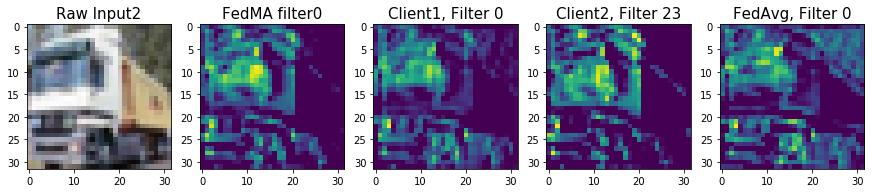

In [73]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(151)
plt.imshow(trainset_cifar10.data[1])
plt.title("Raw Input2", fontsize=15)
plt.subplot(153)
plt.imshow(sliced_output_batch1)
plt.title("Client1, Filter 0", fontsize=15)
plt.subplot(154)
sliced_output_batch2 = output_batch2[0][23].detach().numpy()
plt.imshow(sliced_output_batch2)
plt.title("Client2, Filter 23", fontsize=15)
plt.subplot(152)
output_batch_matched = dumm_conv_block_matched(trial_example)
output_batch_matched = output_batch_matched[0][0].detach().numpy()
plt.imshow(output_batch_matched)
#plt.title("Client1, Filter 0", fontsize=15)
plt.title("FedMA filter0", fontsize=15)
plt.subplot(155)
output_batch_avg = dumm_conv_block_avg(trial_example)
output_batch_avg = output_batch_avg[0][0].detach().numpy()
plt.imshow(output_batch_avg)
plt.title("FedAvg, Filter 0", fontsize=15)

In [75]:
for batch_idx, (train_image_batch, train_label_batch) in enumerate(train_loader):
    if batch_idx == 7:
        trial_example = train_image_batch
    #print(train_image_batch.size())

In [76]:
output_batch1 = dumm_conv_block1(trial_example)
output_batch2 = dumm_conv_block2(trial_example)
output_avg = dumm_conv_block_avg(trial_example)

In [77]:
sliced_output_batch1 = output_batch1[0][0].detach().numpy()

Text(0.5,1,'FedAvg, Filter 0')

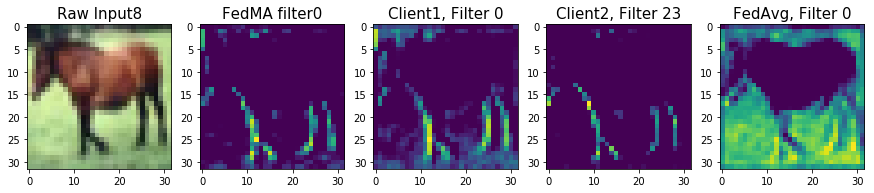

In [79]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(151)
plt.imshow(trainset_cifar10.data[7])
plt.title("Raw Input8", fontsize=15)
plt.subplot(153)
plt.imshow(sliced_output_batch1)
plt.title("Client1, Filter 0", fontsize=15)
plt.subplot(154)
sliced_output_batch2 = output_batch2[0][23].detach().numpy()
plt.imshow(sliced_output_batch2)
plt.title("Client2, Filter 23", fontsize=15)
plt.subplot(152)
output_batch_matched = dumm_conv_block_matched(trial_example)
output_batch_matched = output_batch_matched[0][0].detach().numpy()
plt.imshow(output_batch_matched)
#plt.title("Client1, Filter 0", fontsize=15)
plt.title("FedMA filter0", fontsize=15)
plt.subplot(155)
output_batch_avg = dumm_conv_block_avg(trial_example)
output_batch_avg = output_batch_avg[0][0].detach().numpy()
plt.imshow(output_batch_avg)
plt.title("FedAvg, Filter 0", fontsize=15)